# Lineární klasifikace obrázků CIFAR10

Úkolem cvičení je naprogramovat lineární klasifikátor, který bude rozpoznávat objekty z datasetu CIFAR-10.
Vstupem je RGB obrázek o rozměrech 32$\times$32 pixelů a úkolem říci, který z 10 možných objektů (tříd) je na něm zachycen. Možnosti jsou tyto: letadlo, automobil, pták, kočka, jelen, pes, žába, kůň, loď, náklaďák.

**Model**
- Vstup: $\boldsymbol{x}$, rozměr $N \times D$, kde $N$ je počet obrázků a $D$ počet číselných hodnot v jednom obrázku
  - Každý řádek je jeden obrázek reprezentovaný jako vektor, čísla v rozmezí 0-1.
- Parametr váhy (weights): $\boldsymbol{w}$, rozměr $D \times C$
- Parametr bias: $\boldsymbol{b}$, rozměr $C$
- Predikované skóre (logity): $\boldsymbol{s} = \boldsymbol{x}\cdot\boldsymbol{w} + \boldsymbol{b}$, rozměr $N \times C$
  - Pro každý obrázek predikce $C$ hodnot
- Predikovaná třída: $\boldsymbol{z} = \arg\max_c\boldsymbol{s}$, rozměr $N$
  - Pro každý obrázek vybereme třídu s nejvyšším skóre.

**Optimalizace**
- Kritérium křížová entropie: $l = \sum_c{p_c \cdot \log q_c}$
- Metoda Stochastic Gradient Descent (SGD)
  - $\boldsymbol{w} := \boldsymbol{w} - \gamma \frac{dl}{d\boldsymbol{w}}$
  - $\boldsymbol{b} := \boldsymbol{b} - \gamma \frac{dl}{d\boldsymbol{w}}$
  - Hyperparametr $\gamma$ značí rychlost učení (learning rate)

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('..')  # import tests
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

import ans
from tests import test_linear_classification

In [5]:
torch.set_printoptions(profile='short')

# Načtení dat

Balík torchvision podporuje některé znamé datasety, mezi něž patří i CIFAR-10. Nemusíme tedy data stahovat z internetu manuálně, torchvision za nás vše obstará automaticky. Data uložíme do adresáře `./data`. Všimněme si flagu `train=True`, který říká, že se má načíst trénovací množina datasetu CIFAR-10 (soubory `data_batch_*`).

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
train_dataset

100%|██████████| 170498071/170498071 [00:39<00:00, 4302816.84it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train

Validovat budeme na zbylých 10000 obrázcích. Získáme je nastavením `train=False`.

In [7]:
val_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
val_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

Seznam tříd je uložen v atributu `.classes`.

In [8]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Objekt třídy `torchvision.datasets.cifar.CIFAR10` se chová podobně jako pythonovský `list` s tím, že každý jeho prvek je dvojice (obrázek, třída).

In [9]:
train_dataset[5]

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

Jak vidíme, 6. prvek datasetu je *dvojice* (`tuple`) sestávající z obrázku a jeho indexu třídy (label, target).

- Obrázek je defaultně navrácen jako typ `Image` knihovny Pillow (Python Imaging Library, PIL).

- Target je číslo typu `int` označující jednu ze tříd v atributu `.classes`.

Všechny obrázky CIFAR-10 datasetu jsou uloženy v atributu `.data`, což je 4D `numpy.ndarray` typu `np.uint8`. První dimenze odpovídá jednotlivým obrázkům, další pak řádkům, sloupcům a kanálům (RGB).

In [10]:
type(train_dataset.data), train_dataset.data.shape, train_dataset.data.dtype, train_dataset.data.min(), train_dataset.data.max()

(numpy.ndarray, (50000, 32, 32, 3), dtype('uint8'), 0, 255)

Podobně všechny targety jsou uložny v `.targets`, což je `list` o délce počtu obrázků, přičemž každý target číslo typu `int` v rozmezí 0-9, kde 0 značí letadlo (airplane), 1 značí automobil (automobile) atd.

In [11]:
type(train_dataset.targets), len(train_dataset.targets), type(train_dataset.targets[0]), min(train_dataset.targets), max(train_dataset.targets)

(list, 50000, int, 0, 9)

Pro lepší představu si vykreslíme sloupec 10 obrázků pro každou z 10 tříd.

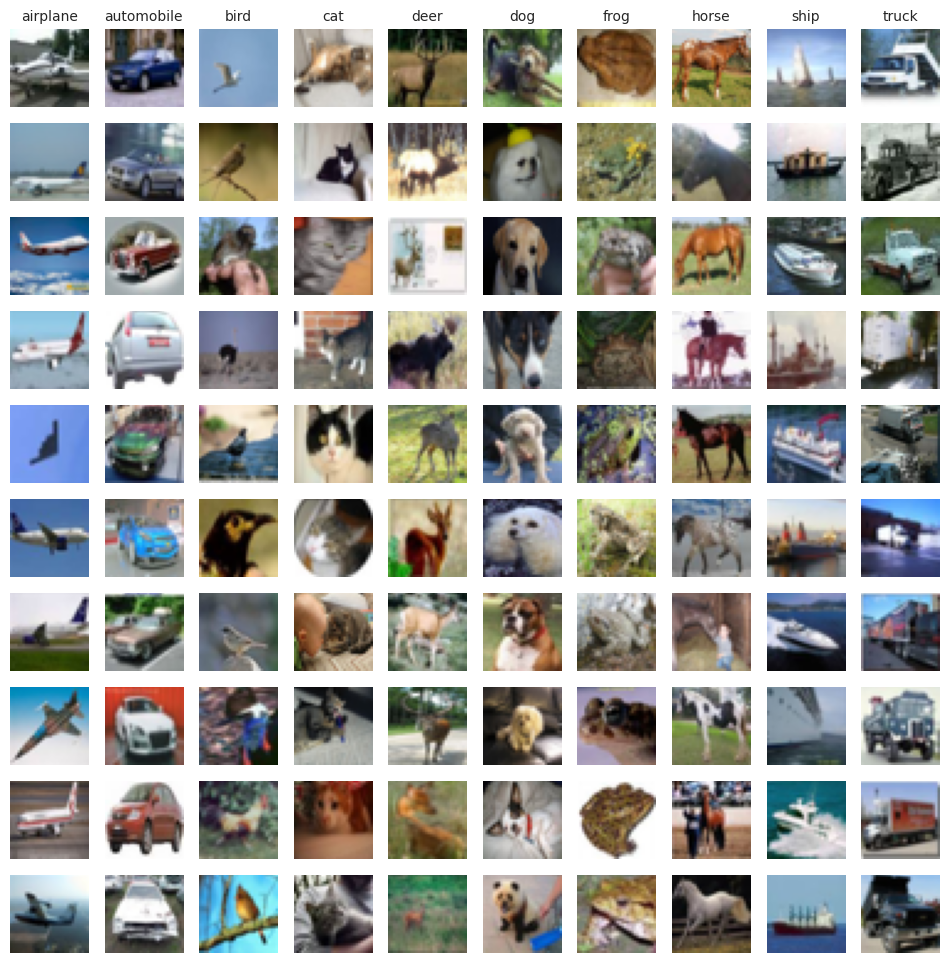

In [12]:
plt.figure(figsize=(12, 12))

for i, cls in enumerate(train_dataset.classes):
    # chceme pouze obrazky aktualni tridy a z nich nahodne vybereme 10
    cls_ids = [j for j, y in enumerate(train_dataset.targets) if y == i]
    draw_ids = np.random.choice(cls_ids, size=10)
    
    # pyplot podobne jako MATLAB nabizi funkci subplot pro vykresleni vice grafu do jednoho okna
    for j, k in enumerate(draw_ids):
        # vykresli 10x10 obrazku, poradi je po radcich, ovsem my budeme vykreslovat po sloupcich,
        # tj. kazdy sloupec bude obsahovat 10 prikladu jedne ze trid
        plt.subplot(10, 10, j * 10 + i + 1)
        
        # vyresli obrazek
        plt.imshow(train_dataset.data[k])
        
        # nevykresluj popisky os
        plt.axis('off')
        
        # v prvnim radku pridame nazev grafu (obrazku)
        if j == 0:
            plt.title(cls, fontsize=10)
plt.show()

# Načítání dat po dávkách

Prvním úkolem bude implementovat načítání dat po dávkách, na kterých se bude klasifikátor učit. Funkcionalita je implementovaná třídou `ans.data.BatchLoader` a nachází se v souboru `ans/data.py`. Třída implementuje metodu `__iter__` a je tedy možné ji použít jako zdroj např. pro `for` cyklus následujícím způsobem:
``` python
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),  # input images, shape (50000, 32, 32, 3)
    torch.tensor(train_dataset.targets),  # targets, shape (50000,)
    batch_size=100,
    shuffle=True  # return the data in random order
)
for inputs, targets in train_loader:
    # inputs ... shape (100, 32, 32, 3)
    # targets ... shape (100,)
    ...
```

### TODO: implementujte metodu `__iter__` třídy `ans.data.BatchLoader`.

Implementaci lze zkontrolovat připravenými unit testy.

In [13]:
test_linear_classification.TestBatchLoader.eval()

test_batch_size_even (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_batch_size_even) ... ok
test_batch_size_uneven (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_batch_size_uneven) ... ok
test_defaults (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_defaults) ... ok
test_output_tuple_supervised (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_tuple_supervised) ... ok
test_output_tuple_unsupervised (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_tuple_unsupervised) ... ok
test_shuffle (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_shuffle) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.008s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [14]:
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),
    torch.tensor(train_dataset.targets),
    batch_size=5,
    shuffle=True
)
train_loader

BatchLoader:
    num_batches: 10000
    batch_shape: (5, 32, 32, 3)

In [15]:
inputs, targets = next(iter(train_loader))
print(type(inputs), inputs.shape, inputs.dtype, inputs.min(), inputs.max())
print(type(targets), targets.shape, targets.dtype, targets.min(), targets.max())

<class 'torch.Tensor'> torch.Size([5, 32, 32, 3]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
<class 'torch.Tensor'> torch.Size([5]) torch.int64 tensor(0) tensor(9)


In [16]:
val_loader = ans.data.BatchLoader(
    torch.tensor(val_dataset.data),
    torch.tensor(val_dataset.targets),
    batch_size=5,
    shuffle=False
)
val_loader

BatchLoader:
    num_batches: 2000
    batch_shape: (5, 32, 32, 3)

# Preprocessing

Data jsou celočiselného typu `torch.uint8`, což jsou čísla v rozmezí 0-255. Pro lepší numerické vlastnosti data převedeme do rozsahu 0-1 a datového typu `torch.float32`, který je pro PyTorch výchozí. Operaci provedeme jednoduchým vydělením max. hodnotou 255. Zároveň obrázky přetvarujeme do vektoru, takže výstup bude mít rozměr (batch_size, počet_pixelů). Celé předzpracování bude implementovat funkce `preprocess`, kterou budeme volat pro každou dávku po jejím načtení z `BatchLoader`u. Normalizovat budeme pouze obrázky, s targety nic dělat nebudeme.

### TODO: implementuje funkci `preprocess`.

In [17]:
def preprocess(inputs: torch.Tensor) -> torch.Tensor:
    """
    Args:
        inputs: n-dimensional tensor with first dimension of size num_inputs
    Returns:
        outputs: 2-dimensional tensor; shape (num_inputs, num_features), dtype float32
    """
    
    ########################################
    # TODO: implement

    inputs = inputs / 255
    outputs = inputs.reshape(inputs.shape[0], -1).to(torch.float32)
    
    
    # ENDTODO
    ########################################
    
    return outputs

In [18]:
test_linear_classification.TestPreprocess.eval(preprocess_fn=preprocess)

test_preprocess (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_preprocess) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [19]:
inputs_prep = preprocess(inputs)
inputs_prep

tensor([[0.71, 0.87,  ..., 0.74, 0.73],
        [0.56, 0.62,  ..., 0.28, 0.12],
        ...,
        [1.00, 1.00,  ..., 1.00, 1.00],
        [0.90, 0.91,  ..., 0.58, 0.54]])

# Inicializace

Váhovou matici $\boldsymbol{W}$ klasifikátoru inicializujeme na náhodné hodnoty s normálním rozdělením a malou standardní odchylkou. Bias $\boldsymbol{b}$ inicializujeme vektor nul s odpovídajícím rozměrem. Inicializaci bude provádět funkce `init_params`, která převezme rozměry a požadovanou odchylku (parametr `multiplier`) a vrátí dvojici (weight, bias).

Pozn.: nezapomínejme, že obrázky jsou uloženy *po řádcích* a náš model má podobu $\boldsymbol{s} = \boldsymbol{x}\cdot\boldsymbol{w} + \boldsymbol{b}$. Od toho se odvíjejí rozměry $\boldsymbol{w}$ a $\boldsymbol{b}$.

### TODO: implementuje funkci `init_params`.

In [20]:
def init_params(input_dim: int, output_dim: int, multiplier: float = 1e-2) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Args:
        input_dim: size of one input
        output_dim: size of one output
        multiplier: standard deviation of weight
    Returns:
        weight, bias
    """
    
    ########################################
    # TODO: implement

    weight = torch.randn(input_dim, output_dim) * multiplier
    bias = torch.zeros(output_dim)
    

    # ENDTODO
    ########################################
    
    return weight, bias

In [21]:
test_linear_classification.TestInit.eval(init_params_fn=init_params)

test_init_params (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init_params) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [22]:
weight, bias = init_params(inputs_prep.shape[1], len(train_dataset.classes))
weight, bias

(tensor([[-0.00,  0.01,  ..., -0.00, -0.00],
         [ 0.01, -0.01,  ..., -0.00, -0.00],
         ...,
         [-0.01,  0.02,  ..., -0.00,  0.01],
         [-0.00,  0.01,  ..., -0.00,  0.01]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# Výpočet lineárních skóre (logitů)

Nyní vypočteme lineární skóre (logity) jako
$$\boldsymbol{s}_n = \boldsymbol{x}_n \cdot \boldsymbol{w} + \boldsymbol{b}$$
kde
- $\boldsymbol{s}_n = [s_{n,1},\ldots,s_{n,C}]$ je (řádkový) vektor skóre pro $n$-tý vzorek (obrázek) $\boldsymbol{x}_n$ a každou z $C$ (= `num_classes`) tříd
- $\boldsymbol{x}_n = [x_{n,1},\ldots,x_{n,D}]$ je $n$-tý vzorek (obrázek) v dávce reprezentovaný jako (řádkový) vektor s rozměrem $D$ (= `num_features`)
- $\boldsymbol{w} = [w_{d,c}]$ je matice vah klasifikátoru s rozměry $D \times C$
- $\boldsymbol{b} = [b_1,\ldots,b_C]$ je bias klasifikátoru - (řádkový) vektor s rozměrem $C$

Výpočet bude zajišťovat funkce `calc_linear_scores`, jejímiž vstupy budou
- dávka vektorů $\boldsymbol{x}=[\boldsymbol{x}_1,\ldots,\boldsymbol{x}_N]$ (každý řádek je jeden vektor) s rozměry $N \times D$
- váhová matice $\boldsymbol{w}$
- bias vektor $\boldsymbol{b}$

a výstupem bude
- *matice* skóre $\boldsymbol{S} = [\boldsymbol{s}_1,\ldots,\boldsymbol{s}_N]$ (každý řádek je jeden vektor skóre $\boldsymbol{s}_n$) s rozměry $N \times C$

### TODO: implementuje funkci `calc_linear_scores`.

In [23]:
def calc_linear_scores(inputs: torch.Tensor, weight: torch.Tensor, bias: torch.Tensor) -> torch.Tensor:
    """
    Args:
        inputs: shape (num_samples, num_features)
        weight: shape (num_features, num_classes)
        bias: shape (num_classes,)
    Returns:
        scores: shape (num_samples, num_classes)
    """
    ########################################
    # TODO: implement

    scores = torch.matmul(inputs, weight) + bias
    
    # ENDTODO
    ########################################
    
    return scores

In [24]:
test_linear_classification.TestCalcLinearScores.eval(calc_linear_scores_fn=calc_linear_scores)

test_calc_linear_scores (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_calc_linear_scores) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [25]:
logits = calc_linear_scores(inputs_prep, weight, bias)
logits

tensor([[-0.91, -0.40, -0.36,  0.52,  0.12,  0.22, -0.78, -0.83, -0.19,  0.25],
        [-0.50, -0.18, -0.06,  0.29, -0.05,  0.08, -0.48, -0.58, -0.04,  0.08],
        [-0.25, -0.22, -0.06,  0.16,  0.34,  0.07, -0.30, -0.33, -0.12, -0.03],
        [-0.90, -0.39, -0.32,  0.55, -0.04,  0.22, -0.87, -1.17, -0.32,  0.26],
        [-0.70, -0.26, -0.11,  0.45, -0.04,  0.21, -0.72, -0.79, -0.32,  0.20]])

# Kritérium: softmax cross entropy loss

Výstupní pravděpodobnost $c$-té třídy $q_{nc}$ predikovaná klasifikátorem pro $\boldsymbol{x}_n$ bychom mohli získat aplikací funkce softmax na skóre $\boldsymbol{s}_n$
$$
q_{n,c} = \frac{\exp{s_{n,c}}}{\sum_{i=1}^{C}{\exp{s_{n,i}}}}, c=1,\ldots,C
$$
kde
- $s_{n,j}$ je predikované skóre jako reálné číslo $(-\infty, +\infty)$ $n$-tého vzorku dávky třídy $j$

Klasifikátor budeme trénovat optimalizací křížové entropie mezi predikovanými $q_{n,c}$ a skutečnými pravděpodobnostmi $p_{n,c}$
$$
l_n = -\sum_c{p_{n,c} \log q_{n,c}}
$$
kde
- $l_n$ je hodnota kritéria (kladné reálné číslo) pro $n$-tý vzorek $\boldsymbol{x}_n$ dávky

Jelikož pro každý obrázek známe, který objekt je na něm zachycen, skutečné diskrétní rozdělení pravděpodobnosti $\boldsymbol{p}_n=[p_{n,1},\ldots,p_{n,C}]$ má pouze jednu hodnotu $p_{n,c}=1$ a to správnou třídu $c=y_n$; ostatní $p_{n,c}=0, c \ne y_n$ jsou nulové. Jde tedy o tzv. one hot vektor. Sloučením softmaxu a odstraněním nulových členů ve vztahu pro výpočet entropie získáme
$$
l_n = -\log q_{n,y_n} = -\log\frac{\exp{s_{n,y_n}}}{\sum_{c=1}^{C}{\exp{s_{n,c}}}} = -s_{n,y_n} + \log\sum_c\exp s_{n,c}
$$
Loss tedy můžeme počítat přímo z lineárních skóre (logitů), což s sebou zároveň přináší výhodu modularity, protože později takto bude možné kritérium jednoduše vyměnit např. za hinge loss a namísto logistické regrese tak trénovat klasifikátor SVM. Kritérium bude počítat funkce `softmax_cross_entropy`, jejímiž vstupy budou
- matice skóre $\boldsymbol{S} = [\boldsymbol{s}_1,\ldots,\boldsymbol{s}_N]$ (každý řádek je jeden vektor skóre $\boldsymbol{s}_n$) s rozměry $N \times C$
- vektor správných indexů tříd $\boldsymbol{y} = [y_1, \ldots, y_N]$ s rozměrem $N$

a výstupy budou
- celkový loss $l = \frac{1}{N}\sum_{n=1}^{N}l_n$ spočítaný jako aritmetický průměr lossů $l_n$ pro jednotlivé predikce $\boldsymbol{s}_1, \ldots, \boldsymbol{s}_N$

### TODO: implementujte funkci `softmax_cross_entropy`

In [28]:
def softmax_cross_entropy(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output linear scores (logits before softmax); shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        loss: averare cross entropy on the batch; tensor containing single number (scalar), e.g. "tensor(2.23)"
    """
    
    ########################################
    # TODO: implement

    scoresOH = scores[torch.arange(scores.shape[0]),targets]
    loss = -scoresOH + torch.logsumexp(scores,1)
    loss = torch.mean(loss)

    # ENDTODO
    ########################################
    
    return loss

In [29]:
test_linear_classification.TestSoftmaxCrossEntropy.eval(softmax_cross_entropy_fn=softmax_cross_entropy)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_softmax_cross_entropy (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_softmax_cross_entropy) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [30]:
loss = softmax_cross_entropy(logits, targets)
loss

tensor(2.65)

# Úspěšnost: accuracy

Kromě lossu budeme pro lepší orientaci měřit i přesnost (accuracy), byť tuto veličinu nebudeme přímo optimalizovat.

### TODO: implementujte funkci `accuracy`.

In [31]:
def accuracy(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output linear scores (logits before softmax); shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        acc: averare accuracy on the batch; tensor containing single number (scalar), e.g. "tensor(0.364)"
    """
    
    ########################################
    # TODO: implement

    acc = torch.sum((scores.argmax(1)==targets))/targets.shape[0]
    
    # ENDTODO
    ########################################
    
    return acc

In [32]:
test_linear_classification.TestAccuracy.eval(accuracy_fn=accuracy)

test_accuracy (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_accuracy) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Gradient na parametry

Optimalizace lossu $l$ bude probíhat stochastickou metodou nejvějtšího spádu (Stochastic Gradient Descent, SGD). K tomu potřebujeme znát gradient na jednotlivé parametry, na kterých $l$ závisí:

Gradient na $c$-tý *sloupec* $\boldsymbol{w}_{:,c}$ matice $\boldsymbol{w}$ platný pro jeden vstup $\boldsymbol{x}_n$:
$$
\frac{\partial l_n}{\partial \boldsymbol{w}_{:,c}} = (q_{n,c} - p_{n,c})\cdot\boldsymbol{x}_n
$$
kde
- $\partial l_n/\partial \boldsymbol{w}_{:,c}$ má rozměr $D \times C$, tj. shodný s $\boldsymbol{w}$
- $\boldsymbol{x}_n = [x_{n,1}, \ldots, x_{n,D}]$ je $n$-tý vzorek dávky jako řádkový vektor s rozměrem $D$
- $q_{n,c}$ je pravděpodobnost (reálné číslo) $c$-té třídy predikovaná pro $x_n$
- $p_{n,c}$ je cílová požadovaná pravděpodobnost (reálné číslo) pro $x_n$

Gradient na $c$-tý prvek biasu platný pro jeden vstup $\boldsymbol{x}_n$:
$$\frac{\partial l_n}{\partial b_c} = (q_{n,c} - p_{n,c})$$

Celkový gradient $\textrm{d}l/\textrm{d}\boldsymbol{w}_{:,c}$ na $c$-tý sloupec vah za celou dávku získáme jako **průměr dílčích příspěvků** za jednotlivé vstupy
$$
\frac{\textrm{d}l}{\textrm{d}\boldsymbol{w}_{:,c}} = \frac{1}{N}\sum_{n=1}^N{ \frac{\partial{l}_n}{\partial \boldsymbol{w}_{:,c}} }
$$
- $N$ je počet vzorků $x_n$ v dávce

Analogicky platí shodně i pro bias.

Oba celkové gradienty za dávku bude vracet funkce `softmax_cross_entropy_gradients`, přičemž vstupem jí budou potřebné proměnné, tj.
- dávka vstupů $\boldsymbol{x} = [\boldsymbol{x}_1, \ldots, \boldsymbol{x}_N]$ s rozměrem $N \times D$
- matice skóre $\boldsymbol{s} = [\boldsymbol{s}_1, \ldots, \boldsymbol{s}_N]$ s rozměrem $N \times C$ 
- vektor správných indexů třídy (targetů) $\boldsymbol{y} = [y_1, \ldots, y_N]$ s rozměrem $N$, $y_c \in \{1, \ldots, C\}$

a výstupem budou
- gradient na váhovou matici $\overline{\boldsymbol{w}} = \textrm{d}l/\textrm{d}\boldsymbol{w}$ jako matice s rozměrem $D \times C$
- gradient na bias $\overline{\boldsymbol{b}} = \textrm{d}l/\textrm{d}\boldsymbol{b}$ jako vektor s rozměrem $C$

### TODO: implementuje funkci `softmax_cross_entropy_gradients`.

In [33]:
def softmax_cross_entropy_gradients(
    inputs: torch.Tensor,
    logits: torch.Tensor,
    targets: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    ########################################
    # TODO: implement

    exp_scores = torch.exp(logits)
    soft_max = exp_scores / exp_scores.sum(1).unsqueeze(1)
    soft_max[torch.arange(targets.shape[0]), targets] -= 1

    dweight = torch.mm(inputs.t(), soft_max/inputs.shape[0])
    dbias = torch.squeeze(torch.mean(soft_max, dim=0, keepdim=True))
    
    # ENDTODO
    ########################################
    
    return dweight, dbias

In [34]:
test_linear_classification.TestSoftmaxCrossEntropyGradients.eval(softmax_cross_entropy_gradients_fn=softmax_cross_entropy_gradients)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_softmax_cross_entropy_gradients (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_softmax_cross_entropy_gradients) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [35]:
dweight, dbias = softmax_cross_entropy_gradients(inputs_prep, logits, targets)
dweight, dbias

(tensor([[-0.31,  0.04,  ...,  0.06, -0.09],
         [-0.34,  0.04,  ...,  0.06, -0.08],
         ...,
         [-0.32, -0.01,  ...,  0.05, -0.04],
         [-0.32, -0.01,  ...,  0.05, -0.03]]),
 tensor([-0.34, -0.12,  0.09,  0.17,  0.12,  0.13, -0.14,  0.06,  0.09, -0.07]))

# Update parametrů

Update bude probíhat metodou největšího spádu (Gradient Descent), tj. od aktuáního odhadu parametrů $\boldsymbol{\theta}$ odečteme gradient $\textrm{d}l/\textrm{d}\boldsymbol{\theta}$ přeškálovaný krokem $\gamma$:

$$\boldsymbol{\theta} := \boldsymbol{\theta} - \gamma \frac{\textrm{d}l}{\textrm{d}\boldsymbol{\theta}}$$

Update implementujeme jako funkci, která převezme parametr, gradient na něj a krok učení $\gamma$ a parametr updatuje. Nebude přitom bytečně vytvářet jeho kopii, vše proběhne modifikací původního tensoru, anglicky tzv. inplace.

### TODO: implementuje funkci `update_param_inplace`.

In [36]:
def update_param_inplace(param: torch.Tensor, dparam: torch.Tensor, learning_rate: float) -> None:
    ########################################
    # TODO: implement

    param -= learning_rate*dparam
    
    # ENDTODO
    ########################################

In [37]:
test_linear_classification.TestUpdateParamInplace.eval(update_param_inplace_fn=update_param_inplace)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_update_param_inplace (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_update_param_inplace) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [38]:
weight, bias

(tensor([[-0.00,  0.01,  ..., -0.00, -0.00],
         [ 0.01, -0.01,  ..., -0.00, -0.00],
         ...,
         [-0.01,  0.02,  ..., -0.00,  0.01],
         [-0.00,  0.01,  ..., -0.00,  0.01]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [39]:
update_param_inplace(weight, dweight, 0.1)
update_param_inplace(bias, dbias, 0.1)

In [40]:
weight, bias

(tensor([[ 0.03,  0.00,  ..., -0.01,  0.01],
         [ 0.04, -0.01,  ..., -0.01,  0.01],
         ...,
         [ 0.02,  0.02,  ..., -0.01,  0.01],
         [ 0.03,  0.01,  ..., -0.01,  0.01]]),
 tensor([ 0.03,  0.01, -0.01, -0.02, -0.01, -0.01,  0.01, -0.01, -0.01,  0.01]))

# Spojení všech kroků dohromady: funkce `train_step` a `val_step`

Nyní spojíme všechny kroky do jedné funkce `train_step_softmax`, která převezme dávku vzorků, aktuální parametry klasifikátoru a hyperparametr krok učení a provede jeden krok směrem k mnimializaci křížové entropie na dávce. Funkce vrátí hodnotu lossu a přesnosti (accuracy) dosaženou na dávce.

### TODO: implementuje funkci `train_step_softmax`

In [41]:
def train_step_softmax(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    weight: torch.Tensor,
    bias: torch.Tensor,
    learning_rate: float = 1e-3
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    inputs = preprocess(inputs)
    scores = calc_linear_scores(inputs, weight, bias)
    acc = accuracy(scores, targets)
    loss = softmax_cross_entropy(scores, targets)
    dweight, dbias = softmax_cross_entropy_gradients(inputs, scores, targets)
    update_param_inplace(weight, dweight, learning_rate)
    update_param_inplace(bias, dbias, learning_rate)
    
    # ENDTODO
    ########################################
    
    return loss.item(), acc.item()

In [42]:
test_linear_classification.TestTrainStepSoftmax.eval(train_step_softmax_fn=train_step_softmax)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_train_step_softmax (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_step_softmax) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### TODO: implementuje funkci `val_step`

In [43]:
def val_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    weight: torch.Tensor,
    bias: torch.Tensor,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], tuple[float, float]]  # e.g. softmax_cross_entropy
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    inputs = preprocess(inputs)
    scores = calc_linear_scores(inputs, weight, bias)
    acc = accuracy(scores, targets)
    loss = loss_fn(scores, targets)
    
    # ENDTODO
    ########################################
    
    return loss.item(), acc.item()

In [44]:
test_linear_classification.TestValStep.eval(val_step_fn=val_step, loss_fn=softmax_cross_entropy)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_val_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_val_step) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.009s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [45]:
def validate(
    loader: ans.data.BatchLoader,
    weight: torch.Tensor,
    bias: torch.Tensor,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], tuple[float, float]]  # e.g. softmax_cross_entropy
) -> tuple[float, float]:
    total_loss = 0.
    total_acc = 0.
    for inputs, targets in loader:
        loss, acc = val_step(inputs, targets, weight, bias, loss_fn)
        total_loss += loss
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

In [46]:
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 50
learning_rate = 5e-3

# data loaders
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),
    torch.tensor(train_dataset.targets),
    batch_size=100,
    shuffle=True
)
val_loader = ans.data.BatchLoader(
    torch.tensor(val_dataset.data),
    torch.tensor(val_dataset.targets),
    batch_size=100,
    shuffle=False
)

# init parameters
weight, bias = init_params(np.prod(train_dataset.data.shape[1:]), len(train_dataset.classes), multiplier=1e-3)

# validate once before training
train_loss, train_acc = validate(train_loader, weight, bias, softmax_cross_entropy)
val_loss, val_acc = validate(val_loader, weight, bias, softmax_cross_entropy)
print(f"after init: train_loss={train_loss:.5f}, train_acc={train_acc:.3f}, val_loss={val_loss:.5f}, val_acc={val_acc:.3f}")

# optimize
for epoch in range(num_epochs):
    # train loop
    for inputs, targets in train_loader:
        loss, acc = train_step_softmax(inputs, targets, weight, bias, learning_rate=learning_rate)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    # train_loss, train_acc = validate(train_loader, weight, bias, softmax_cross_entropy)
    val_loss, val_acc = validate(val_loader, weight, bias, softmax_cross_entropy)
    
    # print
    print(f"epoch {epoch + 1}: train_loss={train_loss:.5f}, train_acc={train_acc:.3f}, val_loss={val_loss:.5f}, val_acc={val_acc:.3f}")

after init: train_loss=2.30397, train_acc=0.106, val_loss=2.30405, val_acc=0.105
epoch 1: train_loss=1.94827, train_acc=0.325, val_loss=1.91822, val_acc=0.351
epoch 2: train_loss=1.87389, train_acc=0.355, val_loss=1.87073, val_acc=0.354
epoch 3: train_loss=1.83597, train_acc=0.368, val_loss=1.83795, val_acc=0.363
epoch 4: train_loss=1.81309, train_acc=0.375, val_loss=1.82027, val_acc=0.375
epoch 5: train_loss=1.80470, train_acc=0.374, val_loss=1.80555, val_acc=0.380
epoch 6: train_loss=1.79851, train_acc=0.382, val_loss=1.79324, val_acc=0.380
epoch 7: train_loss=1.78723, train_acc=0.387, val_loss=1.79258, val_acc=0.379
epoch 8: train_loss=1.76955, train_acc=0.394, val_loss=1.78067, val_acc=0.381
epoch 9: train_loss=1.76910, train_acc=0.396, val_loss=1.77910, val_acc=0.382
epoch 10: train_loss=1.76056, train_acc=0.397, val_loss=1.77062, val_acc=0.385
epoch 11: train_loss=1.76049, train_acc=0.395, val_loss=1.76997, val_acc=0.384
epoch 12: train_loss=1.75644, train_acc=0.399, val_loss=1.7

# Support Vector Machine (SVM)

SVM je softmaxu velmi podobné. Z pohledu neuronových sítí se liší pouze způsobem výpočtu lossu - místo (softmax) cross entropy použijeme hinge loss:
$$l_n = \sum_{c\ne y_n}\max(0, 1 + s_{n,c} - s_{n,y_n})$$
kde:
- $y_n \in \{1, \ldots, C\}$ je správný index třídy (celé číslo) na vzorku (obrázku) $\boldsymbol{x}_n$
- $s_{n,i}$ je skóre (logity) predikované lineárním klasifikátorem pro $n$-tý obrázek a $i$-tou třídu.

Podobně jako u `softmax_cross_entropy` celkový loss
$$
l = \frac{1}{N}\sum_{n=1}^{N}l_n
$$
spočítáme jako aritmetický průměr lossů $l_n$ pro jednotlivé predikce $\boldsymbol{s}_1, \ldots, \boldsymbol{s}_N$.

Gradient na $c$-tý sloupec $\boldsymbol{w}_{:,c}$ váhové matice $\boldsymbol{w}$ pak je
$$
\frac{\partial l_n}{\partial \boldsymbol{w}_{:,c}} = \begin{cases}
    \sum_{c\ne y_n}\mathbb{1}(1 + s_{n,c} - s_{n,y_n} > 0)\cdot\boldsymbol{x}_n & \textrm{pokud} & c = y_n \\
    \mathbb{1}(1 + s_{n,c} - s_{n,y_n} > 0) \cdot \boldsymbol{x}_n & \textrm{pokud} & c \ne y_n
\end{cases}
$$
kde
- $\mathbb{1}(\cdot) = 1$, pokud podmínka $\cdot$ je splněna, jinak $\mathbb{1}(\cdot) = 0$

Jelikož dílčí lossy za jednotliové vzorky v dávce průměrujeme, i jejich gradienty je nutné zprůměrovat
$$
\frac{\textrm{d}l}{\textrm{d}\boldsymbol{w}_{:,c}} = \frac{1}{N} \sum_{n=1}^{N}{ \frac{\partial l_n}{\partial \boldsymbol{w}_{:,c}} }
$$
Pro biasy platí vše podobně jako pro váhy, pouze bez násobení $\boldsymbol{x}_n$
$$
\frac{\partial l_n}{\partial b_c} = \begin{cases}
    \sum_{c\ne y_n}\mathbb{1}(1 + s_{n,c} - s_{n,y_n} > 0) & \textrm{pokud} & c = y_n \\
    \mathbb{1}(1 + s_{n,c} - s_{n,y_n} > 0) & \textrm{pokud} & c \ne y_n
\end{cases}
$$
a
$$
\frac{\textrm{d}l}{\textrm{d}b_c} = \frac{1}{N} \sum_{n=1}^{N}{ \frac{\partial l_n}{\partial b_c} }
$$

### TODO: implementuje funkce `hinge_loss`, `hinge_loss_gradients` a `train_step_svm`

In [47]:
def hinge_loss(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output from linear classifier, i.e. the pre-softmax logits; shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        loss: average Weston-Watkins hinge loss on the batch; tensor containing single number (scalar), e.g. "tensor(2.374)"
    """
    
    ########################################
    # TODO: implement

    s_ny = scores[torch.arange(scores.shape[0]), targets]
    mask = torch.ones_like(scores).scatter_(1, targets.unsqueeze(1), 0.)
    s_nc = scores[mask.bool()].view(scores.shape[0], scores.shape[1]-1)
    loss = torch.max(torch.zeros(scores.shape[0], scores.shape[1]-1), 1+s_nc-s_ny.unsqueeze(1))
    loss = torch.mean(torch.sum(loss, dim=1))
    
    # ENDTODO
    ########################################
    
    return loss

In [48]:
test_linear_classification.TestHingeLoss.eval(hinge_loss_fn=hinge_loss)

test_hinge_loss (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_hinge_loss) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_no_loops (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_no_loops) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [50]:
def hinge_loss_gradients(
    inputs: torch.Tensor,
    scores: torch.Tensor,
    targets: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    
    ########################################
    # TODO: implement
    N = inputs.shape[0]
    num_c = scores.shape[1]

    scores_c = scores[torch.arange(N), targets].unsqueeze(1)
    margins = torch.where(1 + scores - scores_c > 0, 1.0, 0.0)
    mask = torch.ones_like(margins).scatter_(1, targets.unsqueeze(1), 0)
    margins[torch.arange(N), targets] = -torch.sum(margins[mask.bool()].view(N, num_c-1), dim=1)
    dweight = torch.mm(inputs.t(), margins)/N
    dbias = torch.mean(margins, dim=0)
    
    
    # ENDTODO
    ########################################
    
    return dweight, dbias

In [51]:
test_linear_classification.TestHingeLossGradients.eval(hinge_loss_gradients_fn=hinge_loss_gradients)

test_hinge_loss_gradients (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_hinge_loss_gradients) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [52]:
def train_step_svm(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    weight: torch.Tensor,
    bias: torch.Tensor,
    learning_rate: float = 1e-3
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    inputs = preprocess(inputs)
    scores = calc_linear_scores(inputs, weight, bias)
    acc = accuracy(scores, targets)
    loss = hinge_loss(scores, targets)
    dweight, dbias = hinge_loss_gradients(inputs, scores, targets)
    update_param_inplace(weight, dweight, learning_rate)
    update_param_inplace(bias, dbias, learning_rate)
    
    # ENDTODO
    ########################################
    
    return loss.item(), acc.item()

In [53]:
test_linear_classification.TestTrainStepSVM.eval(train_step_svm_fn=train_step_svm)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_train_step_svm (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_step_svm) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.009s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [54]:
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 50
learning_rate = 5e-4

# data loaders
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),
    torch.tensor(train_dataset.targets),
    batch_size=100,
    shuffle=True
)
val_loader = ans.data.BatchLoader(
    torch.tensor(val_dataset.data),
    torch.tensor(val_dataset.targets),
    batch_size=100,
    shuffle=False
)

# init parameters
weight, bias = init_params(np.prod(train_dataset.data.shape[1:]), len(train_dataset.classes), multiplier=1e-3)

# validate once before training
train_loss, train_acc = validate(train_loader, weight, bias, hinge_loss)
val_loss, val_acc = validate(val_loader, weight, bias, hinge_loss)
print(f"after init: train_loss={train_loss:.5f}, train_acc={train_acc:.3f}, val_loss={val_loss:.5f}, val_acc={val_acc:.3f}")

# optimize
for epoch in range(num_epochs):
    # train loop
    for xb, yb in train_loader:
        loss, acc = train_step_svm(xb, yb, weight, bias, learning_rate=learning_rate)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    # train_loss, train_acc = validate(train_loader, weight, bias, hinge_loss)
    val_loss, val_acc = validate(val_loader, weight, bias, hinge_loss)
    
    # print
    print(f"epoch {epoch + 1}: train_loss={train_loss:.5f}, train_acc={train_acc:.3f}, val_loss={val_loss:.5f}, val_acc={val_acc:.3f}")

after init: train_loss=9.00865, train_acc=0.106, val_loss=9.00949, val_acc=0.105
epoch 1: train_loss=5.55917, train_acc=0.321, val_loss=5.39162, val_acc=0.336
epoch 2: train_loss=5.12689, train_acc=0.346, val_loss=5.13282, val_acc=0.342
epoch 3: train_loss=4.93019, train_acc=0.360, val_loss=4.96277, val_acc=0.347
epoch 4: train_loss=4.80358, train_acc=0.361, val_loss=4.84566, val_acc=0.365
epoch 5: train_loss=4.74897, train_acc=0.362, val_loss=4.78868, val_acc=0.362
epoch 6: train_loss=4.72831, train_acc=0.371, val_loss=4.73701, val_acc=0.363
epoch 7: train_loss=4.66517, train_acc=0.372, val_loss=4.70223, val_acc=0.368
epoch 8: train_loss=4.60361, train_acc=0.378, val_loss=4.65701, val_acc=0.367
epoch 9: train_loss=4.59415, train_acc=0.380, val_loss=4.66229, val_acc=0.363
epoch 10: train_loss=4.55139, train_acc=0.376, val_loss=4.61698, val_acc=0.373
epoch 11: train_loss=4.53288, train_acc=0.377, val_loss=4.62201, val_acc=0.366
epoch 12: train_loss=4.52450, train_acc=0.382, val_loss=4.6